In [32]:

!pip -q install scikit-image

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.filters import threshold_niblack, threshold_sauvola
from sklearn.metrics import confusion_matrix

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import os
os.listdir('/content/drive/MyDrive')

['Untitled document (20).gdoc',
 'Untitled document (19).gdoc',
 'Untitled document (18).gdoc',
 'Untitled document (17).gdoc',
 'Untitled document (16).gdoc',
 'Untitled document (15).gdoc',
 'Untitled document (14).gdoc',
 'Untitled document (13).gdoc',
 'Untitled document (12).gdoc',
 'Untitled document (11).gdoc',
 'Untitled document (10).gdoc',
 'Untitled document (9).gdoc',
 'Untitled document (8).gdoc',
 'Untitled document (7).gdoc',
 'Untitled document (6).gdoc',
 'Untitled document (5).gdoc',
 'CS23B1021.gdoc',
 'Portfolio.gsite',
 'Project proposal.gdoc',
 'Untitled document - Pie chart 1 (1).gsheet',
 'Untitled document (4).gdoc',
 'Untitled document (3).gdoc',
 'Untitled document - Pie chart 1.gsheet',
 'Untitled document (2).gdoc',
 'imp.gdoc',
 'Untitled document (1).gdoc',
 'cs23b1021-Assignment.gdoc',
 'lab11,1:cs23b1021.gdoc',
 'CS23B1021-lab-12.gdoc',
 'Project-1.gdoc',
 'Untitled document.gdoc',
 'PROJECT REPORT.gslides',
 'Project Report: Image Colorization with PIL

In [35]:

import zipfile
import os

zip_path = "/content/drive/MyDrive/dataset-3.zip"
extract_path = "/content/drive/MyDrive/dataset-3"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped successfully ✅")

Unzipped successfully ✅


In [36]:
base_path = "/content/drive/MyDrive/dataset-3/DRIVE"

image_dir = os.path.join(base_path, "training/images")
mask_dir  = os.path.join(base_path, "training/1st_manual")

print("Images:", len(os.listdir(image_dir)))
print("Masks :", len(os.listdir(mask_dir)))

Images: 20
Masks : 20


In [45]:
def compute_metrics(gt, pred):
    gt = gt.flatten()
    pred = pred.flatten()

    tn, fp, fn, tp = confusion_matrix(gt, pred, labels=[0,1]).ravel()

    sensitivity = tp / (tp + fn + 1e-8)
    specificity = tn / (tn + fp + 1e-8)
    accuracy    = (tp + tn) / (tp + tn + fp + fn + 1e-8)
    dice        = (2 * tp) / (2 * tp + fp + fn + 1e-8)

    return sensitivity, specificity, accuracy, dice

In [46]:
niblack_results = []
sauvola_results = []

image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".tif")])
print("Processing images:", len(image_files))

while len(image_files) > 0:
    name = image_files.pop(0)

    img_path = os.path.join(image_dir, name)

    base_num = name.split("_")[0] if "_" in name else name.split(".")[0]
    mask_name = base_num + "_manual1.gif"
    mask_path = os.path.join(mask_dir, mask_name)

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    gt  = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print("❌ Image missing:", img_path)
        continue

    if gt is None:
        print("❌ Mask missing:", mask_path)
        continue

    gt = (gt > 0).astype(np.uint8)


    thresh_nib = threshold_niblack(img, window_size=25, k=0.2)
    pred_nib = (img > thresh_nib).astype(np.uint8)
    niblack_results.append(compute_metrics(gt, pred_nib))


    thresh_sau = threshold_sauvola(img, window_size=25, k=0.2)
    pred_sau = (img > thresh_sau).astype(np.uint8)
    sauvola_results.append(compute_metrics(gt, pred_sau))

print("Done. Processed:", len(niblack_results))

Processing images: 20
Done. Processed: 20


In [48]:
mask_name = name.replace(".tif", "_manual1.gif")

In [49]:
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".tif")])
print("Total images found:", len(image_files))

Total images found: 20


In [52]:
if len(niblack_results) == 0:
    print("🚨 No images processed — check paths or filenames!")
else:
    niblack_results = np.array(niblack_results)
    sauvola_results = np.array(sauvola_results)

    results = pd.DataFrame({
        "Metric": ["Sensitivity", "Specificity", "Accuracy", "Dice"],
        "Niblack": np.mean(niblack_results, axis=0),
        "Sauvola": np.mean(sauvola_results, axis=0)
    })

    display(results)

,Metric,Niblack,Sauvola
0,Sensitivity,0.208882,0.944774
1,Specificity,0.351819,0.100634
2,Accuracy,0.339788,0.173401
3,Dice,0.052186,0.164391


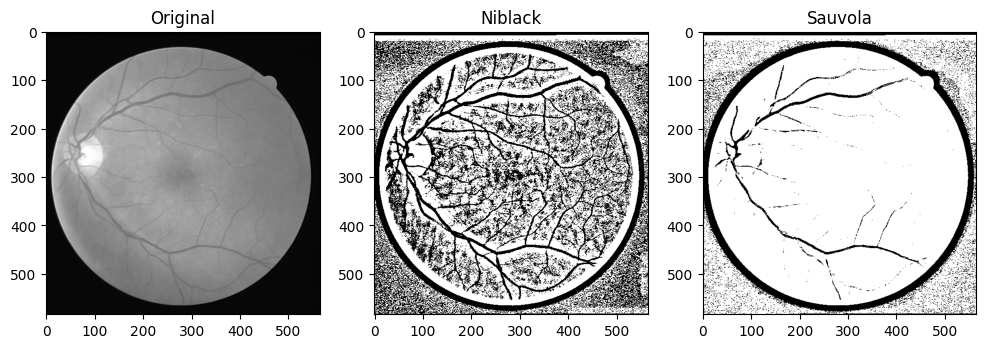

In [30]:

sample_name = sorted(os.listdir(image_dir))[0]

img = cv2.imread(os.path.join(image_dir, sample_name), 0)

th_nib = threshold_niblack(img, 25, k=0.2)
pred_nib = img > th_nib

th_sau = threshold_sauvola(img, 25, k=0.1)
pred_sau = img > th_sau

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title("Original")

plt.subplot(1,3,2)
plt.imshow(pred_nib, cmap='gray')
plt.title("Niblack")

plt.subplot(1,3,3)
plt.imshow(pred_sau, cmap='gray')
plt.title("Sauvola")

plt.show()

Sauvola thresholding achieves very high sensitivity, meaning it detects most retinal vessels, especially thin ones, but it suffers from extremely low specificity and accuracy due to many false positives and noise. Niblack provides slightly better specificity but misses many vessels, leading to low sensitivity. The low Dice scores for both methods indicate poor overall segmentation quality on the DRIVE dataset. Therefore, while Sauvola is better for vessel detection, both methods require preprocessing and post-processing to obtain reliable retinal vessel extraction.
